In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

from src.utils.training_utils import get_device_map

model_key = "meta-llama/Llama-3.3-70B-Instruct"

device_map = get_device_map(model_key, 32, n_gpus=8)
print(device_map)

os.chdir("/disk/u/gio/mechinterp")
print(os.getcwd())

from src.models import ModelandTokenizer

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    device_map=device_map,
    attn_implementation="eager",
)


2025-09-03 17:42:08 __main__ INFO     torch.__version__='2.8.0+cu128', torch.version.cuda='12.8'
2025-09-03 17:42:09 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-03 17:42:09 __main__ INFO     transformers.__version__='4.54.1'
2025-09-03 17:42:11 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-03 17:42:11 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
{'model.embed_tokens': 7, 'model.norm': 7, 'model.rotary_emb': 7, 'lm_head': 7, 'model.layers.0': 0, 'model.layers.1': 1, 'model.layers.2': 2, 'model.layers.3': 3, 'model.layers.4': 4, 'model.layers.5': 5, 'model.layers.6': 6, 'model.layers.7': 7, 'model.layers.8': 0, 'model.layers.9': 1, 'model.layers.10': 2, 'model.layers.11': 3, 'model.layers.12': 4, 'model.layers.13': 5,

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-03 17:43:02 src.models INFO     loaded model <models/meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:7


2025-09-03 17:43:02 matplotlib DEBUG    matplotlib data path: /disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-03 17:43:02 matplotlib DEBUG    CONFIGDIR=/disk/u/gio/.config/matplotlib
2025-09-03 17:43:02 matplotlib DEBUG    interactive is False
2025-09-03 17:43:02 matplotlib DEBUG    platform is linux
2025-09-03 17:43:02 matplotlib DEBUG    CACHEDIR=/disk/u/gio/.cache/matplotlib
2025-09-03 17:43:02 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/gio/.cache/matplotlib/fontlist-v390.json
2025-09-03 17:43:02 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-03 17:43:02 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-03 17:43:02 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-03 17:43:02 matplotlib.font_manager DEB

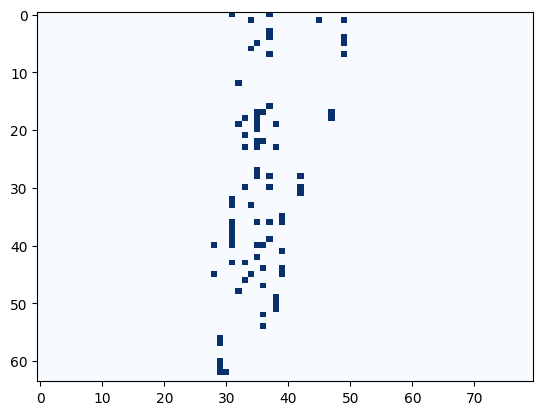

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.selection.data import SelectOneTask

optimized_path = os.path.join(
    "/disk/u/arnab/Codes/Projects/retrieval/results/"
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "distinct_options",
    "select_one",
    "epoch_10.npz"
)
optimization_results = np.load(optimized_path, allow_pickle=True)
optimal_head_mask = torch.tensor(optimization_results['optimal_mask']).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))


In [4]:
TASK_CLS = SelectOneTask
N_DISTRACTORS = 5
prompt_template_idx = 3
OPTION_STYLE = "single_line"

rhyme_task = TASK_CLS.load(
    path="/disk/u/gio/retrieval/data_save/selection/rhymes.json"
)

print(rhyme_task.task_name)

select_one


In [5]:
q_before_sample_set = []
sample_size = 10

while len(q_before_sample_set) < sample_size:
    sample = rhyme_task.get_random_sample(
        mt
    )
    q_before_sample_set.append(sample)

print(q_before_sample_set[0])

pie -> lie (2): ['they', 'shoe', 'lie', 'frown', 'vet', 'show']


In [6]:
q_after_sample_set = []
sample_size = 10

while len(q_after_sample_set) < sample_size:
    sample = rhyme_task.get_random_sample(
        mt,
        prompt_template_idx=1
    )
    q_after_sample_set.append(sample)

print(q_after_sample_set[0])

say -> may (3): ['that', 'let', 'sake', 'may', 'renown', 'she']


In [7]:
from circuitsvis.tokens import colored_tokens

def patch(
    model,
    tokenizer,
    inputs,
    model_kwargs,
):
    seq_len = inputs.input_ids

def get_model_out(
    input,
    model,
    tokenizer
):

    with model.trace(input, output_attentions=True):
        output = model.model.output.save()
        logits = model.lm_head.output.save()
    return output, logits

def visualize_attn_matrix(
    attn_matrix: torch.Tensor,
    tokens: list[str],
    q_index: int = -1,
    start_from: int = 1,
):
    assert len(tokens) == attn_matrix.shape[-1], (
        f"{len(tokens)=}, {attn_matrix.shape[-1]=}"
    )
    attn_matrix = attn_matrix[q_index][start_from:]
    tokens = tokens[start_from:]
    display(colored_tokens(tokens=tokens, values=attn_matrix))

def verify_head_patterns(
    prompt,
    model,
    tokenizer,
    heads = None,
    query_idx = -1,
    start_from = 1
):

    tokenized_prompt_ids = tokenizer(prompt).input_ids
    str_tokens = tokenizer.convert_ids_to_tokens(tokenized_prompt_ids)
    str_tokens = [s.replace("Ġ", " ") for s in str_tokens]
    str_tokens = [s.replace("Ċ", " ") for s in str_tokens]

    return_dict = {}

    output, logits = get_model_out(
        input=prompt,
        model=model,
        tokenizer=tokenizer,
    )
    output_attns = [attn[0].cuda() for attn in output.attentions]
    attn_matrices = torch.stack(output_attns, dim=0)

    #print(attn_matrices.shape)

    if heads is not None and len(heads) > 0:
        combined = []
        if len(heads[0]) == 3:
            for layer_idx, head_idx, _ in heads:
                head_matrix = torch.Tensor(
                attn_matrices[layer_idx, head_idx].squeeze()
                )
                combined.append(head_matrix)
        elif len(heads[0]) == 2:
            for layer_idx, head_idx in heads:
                    head_matrix = torch.Tensor(
                    attn_matrices[layer_idx, head_idx].squeeze()
                    )
                    combined.append(head_matrix)

        combined_matrix = torch.stack(combined).mean(dim=0)

        visualize_attn_matrix(
            attn_matrix=combined_matrix,
            tokens=str_tokens,
            q_index=query_idx,
            start_from=start_from,
        )
    
    return attn_matrices

In [8]:
for sample in q_before_sample_set:
    verify_head_patterns(
        prompt=sample.prompt(),
        model=mt,
        tokenizer=mt.tokenizer,
        heads=heads_selected,
        query_idx=-1,
    )

In [9]:
for sample in q_after_sample_set:
    verify_head_patterns(
        prompt=sample.prompt(),
        model=mt,
        tokenizer=mt.tokenizer,
        heads=heads_selected,
        query_idx=-1,
    )

In [24]:
from src.attention import (
    get_attention_matrices,
    visualize_average_attn_matrix,
    visualize_attn_matrix,
)
from src.functional import interpret_logits, PatchSpec, get_hs, generate_with_patch
from src.tokens import prepare_input, find_token_range
from itertools import product
from src.utils.typing import TokenizerOutput


def get_patches_to_verify_independent_enrichment(
    prompt: str,
    options: list[str],
    pivot: str,
    mt: ModelandTokenizer,
    bare_prompt_template: str = " The fact that {}",
    tokenized_prompt: TokenizerOutput | None = None,
):
    if tokenized_prompt and "offset_mapping" not in tokenized_prompt:
        tokenized_prompt = prepare_input(
            tokenizer=mt,
            prompts=prompt,
            return_offsets_mapping=True,
        )

    offsets = tokenized_prompt.pop("offset_mapping")[0]
    patches = []
    for opt in options:
        opt_range = find_token_range(
            tokenizer=mt,
            string=prompt,
            substring=opt,
            offset_mapping=offsets,
        )
        bare_prompt = bare_prompt_template.format(opt)
        bare_tokenized = prepare_input(
            tokenizer=mt,
            prompts=bare_prompt,
            return_offsets_mapping=True,
        )
        bare_offsets = bare_tokenized.pop("offset_mapping")[0]
        bare_opt_range = find_token_range(
            tokenizer=mt,
            string=bare_prompt,
            substring=opt,
            offset_mapping=bare_offsets,
        )
        #logger.debug(
        #    f'{opt} | {opt_range=} | {bare_opt_range=} | "{mt.tokenizer.decode(tokenized_prompt.input_ids[0][range(*opt_range)])}"'
        #)
        assert (
            opt_range[1] - opt_range[0] == bare_opt_range[1] - bare_opt_range[0]
        ), f"Option range {opt_range} and bare option range {bare_opt_range} do not match for option '{opt}' in prompt '{prompt}'"

        bare_hs = get_hs(
            mt=mt,
            input=bare_prompt,
            locations=list(product(mt.layer_names, range(*bare_opt_range))),
            return_dict=True,
            patches=[],
        )

        for bare_idx, clean_idx in zip(range(*bare_opt_range), range(*opt_range)):
            patches.extend(
                PatchSpec(
                    location=(module_name, clean_idx),
                    patch=bare_hs[(module_name, bare_idx)],
                )
                for module_name in mt.layer_names
            )

    return patches


def verify_head_patterns(
    prompt: str,
    options: list[str],
    pivot: str,
    mt: ModelandTokenizer,
    layers: list[int] = None,
    heads: list[tuple[int, int]] = None,
    value_weighted: bool = False,
    generate_full_answer: bool = False,
    ablate_possible_ans_info_from_options: bool = False,
    bare_prompt_template=" The fact that {}",
    combined_only = True,
):
    tokenized_prompt = prepare_input(
        tokenizer=mt,
        prompts=prompt,
        return_offsets_mapping=True,
    )
    patches = (
        get_patches_to_verify_independent_enrichment(
            prompt=prompt,
            options=options,
            pivot=pivot,
            mt=mt,
            tokenized_prompt=tokenized_prompt,
            bare_prompt_template=bare_prompt_template,
        )
        if ablate_possible_ans_info_from_options
        else []
    )
    #print(len(patches), "patches to ablate possible answer information from options")

    ret_dict = {}
    if generate_full_answer:
        gen = generate_with_patch(
            mt=mt,
            inputs=prompt,
            n_gen_per_prompt=1,
            max_new_tokens=30,
            patches=patches,
            remove_prefix=True
        )[0]
        logger.debug(f'Generated full answer: "{gen}"')
        ret_dict["full_answer"] = gen

    attn_matrices = get_attention_matrices(
        input=tokenized_prompt, mt=mt, value_weighted=value_weighted, patches=patches
    )
    logits = attn_matrices.logits

    predictions = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=logits,
    )
    #logger.debug(f"Predictions: {[str(p) for p in predictions]}")
    ret_dict["predictions"] = predictions
    ret_dict["logits"] = logits
    ret_dict["attn_matrices"] = attn_matrices

    if layers is not None and len(layers) > 0:
        visualize_average_attn_matrix(
            mt=mt,
            attn_matrices=attn_matrices,
            prompt=prompt,
            tokenized=tokenized_prompt,
            layer_window=layers,
        )
        print("=" * 70)

    if heads is not None and len(heads) > 0:
        combined = []
        for layer_idx, head_idx in heads:
            #logger.info(f"Layer: {layer_idx}, Head: {head_idx}")
            head_matrix = torch.Tensor(
                attn_matrices.attention_matrices[layer_idx, head_idx].squeeze()
            )
            combined.append(head_matrix)

            if not combined_only:
                visualize_attn_matrix(
                    attn_matrix=head_matrix,
                    tokens=attn_matrices.tokenized_prompt,
                    q_index=-1,
                    start_from=1,
                )

        if len(combined) > 1:
            #logger.info("Combined attention matrix for all heads")
            combined_matrix = torch.stack(combined).mean(dim=0)
            visualize_attn_matrix(
                attn_matrix=combined_matrix,
                tokens=attn_matrices.tokenized_prompt,
                q_index=-1,
                start_from=1,
            )

    return ret_dict

In [ ]:
for sample in q_before_sample_set:

    verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=heads_selected,
        value_weighted=False,
        # generate_full_answer=True,
        ablate_possible_ans_info_from_options=True,
    )

AssertionError: Option range (10, 12) and bare option range (4, 5) do not match for option 'row' in prompt 'Which word from the following list rhymes with frown?
Options: right, row, shoe, mat, noun, me.
Answer:'

: 